In [40]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from mlxtend.plotting import plot_decision_regions

In [13]:
X,y =make_classification(n_samples=5000, n_features=2, n_informative=2, n_classes=2, n_clusters_per_class=1,
                        n_redundant=0,n_repeated=0,weights=[0.01,0.99],class_sep=0.8,random_state=0)
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=0)
print("Dados em cada uma das classes - total dos dados",sorted(Counter(y).items()))
print("Dados em cada uma das classes - y_train",sorted(Counter(y_train).items()))
print("Dados em cada uma das classes - y_test",sorted(Counter(y_test).items()))

Dados em cada uma das classes - total dos dados [(0, 77), (1, 4923)]
Dados em cada uma das classes - y_train [(0, 65), (1, 3685)]
Dados em cada uma das classes - y_test [(0, 12), (1, 1238)]


In [17]:
# funcão usada para imprimir a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

======================================================

## Um random Forest com dados "imbalanced"

score para RandomForest: 0.996


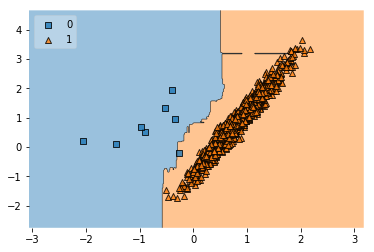

In [18]:
rf1=RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, n_jobs=None, 
                           random_state=0, verbose=0, warm_start=True, class_weight=None)
rf1.fit(x_train,y_train)
y_pred1=rf1.predict(x_test)
print("score para RandomForest:",rf1.score(x_test,y_test))
p_rf1=rf1.predict_proba(x_test)
plot_decision_regions(X=x_test,y=y_test,clf=rf1,legend=2);

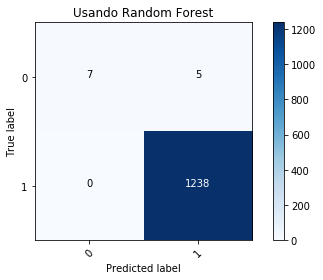

In [19]:
cm_rf1 = confusion_matrix(y_test, y_pred1)
plt.figure()
plot_confusion_matrix(cm_rf1, classes=[0,1],
                      title='Usando Random Forest')

Podemos tentar melhorar os resultados encontrados acima a partir de vários melhoramentos. O mais interessante seria aplicar o GridSearchCV para encontrar os parâmetros ótimos e, além disso, fazer uso do K-Fold para aplicar o modelo a diferentes conjuntos de amostras dos nossos dados.

### GridSearchCV em um Random Forest
Nosso primeiro teste será aplicar o método de GridSearchCV para encontrar os parâmetros ótimos. Como primeiro passo, vamos ver quais parâmetros que temos disponíveis. Veja que são várias opções e teremos que testar apenas algumas delas.

In [22]:
rf1.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': True}

Primeiro definimos os intervalos de oscilação dos parâmetros que queremos otimizar.

In [23]:
# parâmetros a serem testados
estimadores=[int(x) for x in np.linspace(start=200,stop=2000,num=10)]
features=['auto','sqrt']
arvores=[int(x) for x in np.linspace(10,110,num=11)]
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]

A seguir colocamos os mesmos em um formato de dicionário.

In [26]:
grid={'n_estimators':estimadores,
     'max_features': features,
     'max_depth':arvores,
     'min_samples_split':min_samples_split,
     'min_samples_leaf':min_samples_leaf,
     'bootstrap':bootstrap}

E agora, como opção, primeiro usamos o recurso do RandomizedSearchCV que procura valores que melhor se adaptam ao modelo.

In [28]:
classificador=RandomForestClassifier()
rf_random=RandomizedSearchCV(estimator=classificador,param_distributions=grid,n_iter=100,
                             cv=5,verbose=0,random_state=None,n_jobs=-1)
rf2=rf_random.fit(x_train,y_train)
rf2.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [37]:
print(rf2.best_estimator_)
print('')
print('Score',rf2.best_estimator_.score(x_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Score 0.996


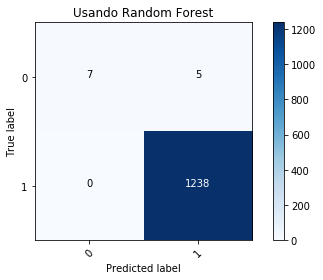

In [38]:
y_pred2=rf2.best_estimator_.predict(x_test)
cm_rf2 = confusion_matrix(y_test, y_pred2)
plt.figure()
plot_confusion_matrix(cm_rf2, classes=[0,1],
                      title='Usando Random Forest')

Veja que tivemos pouca melhora no resultado. Agora podemos pegar os valores dos hiperparâmetros encontrados pelo RandomSearchCV e usar o GridSearchCV.

In [43]:
estimadores2=[int(x) for x in np.linspace(2000,2500,num=5)]
features2=['sqrt']
arvores2=[int(x) for x in np.linspace(100,110,num=5)]
min_samples_split2=[2]
min_samples_leaf2=[1]
bootstrap2=[True]
#
grid2={'n_estimators':estimadores2,
     'max_features': features2,
     'max_depth':arvores2,
     'min_samples_split':min_samples_split2,
     'min_samples_leaf':min_samples_leaf2,
     'bootstrap':bootstrap2}
#
classificador2=RandomForestClassifier()
rf_GS=GridSearchCV(estimator=classificador2,param_grid=grid2,cv=5,verbose=0,n_jobs=-1)
rf3=rf_GS.fit(x_train,y_train)
rf3.best_params_

{'bootstrap': True,
 'max_depth': 102,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2125}

In [44]:
print(rf3.best_estimator_)
print('')
print('Score',rf3.best_estimator_.score(x_test,y_test))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=102, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2125, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Score 0.996


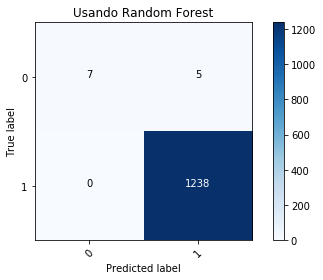

In [45]:
y_pred3=rf3.best_estimator_.predict(x_test)
cm_rf3 = confusion_matrix(y_test, y_pred3)
plt.figure()
plot_confusion_matrix(cm_rf3, classes=[0,1],
                      title='Usando Random Forest')

=========================================================

## Um Random Forest corrigindo o "imbalance"

In [46]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced

A ideia aqui é aplicar o GridSearchCV ao algoritmo "BalancedRandomForestClassifier", que está no pacote imbalanced_learn usando os intervalos das variáveis já discutidas anteriormente. Veja que o estimador é outro, que já corrige pelo problema dos dados "desbalanceados". 

In [48]:
brf=BalancedRandomForestClassifier()
brf_GS=GridSearchCV(estimator=brf,param_grid=grid2,cv=5,verbose=0,n_jobs=-1)
brf1=brf_GS.fit(x_train,y_train)
brf1.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2125}

In [49]:
print(brf1.best_estimator_)
print('')
print('Score',brf1.best_estimator_.score(x_test,y_test))

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=100, max_features='sqrt',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=2125, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

Score 0.8528


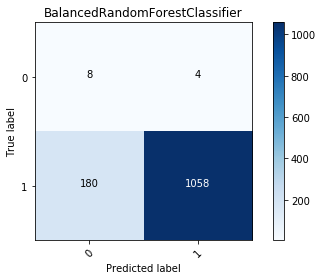

In [51]:
y_pred4=brf1.best_estimator_.predict(x_test)
cm_rf4 = confusion_matrix(y_test, y_pred4)
plt.figure()
plot_confusion_matrix(cm_rf4, classes=[0,1],title='BalancedRandomForestClassifier')